<a href="https://colab.research.google.com/github/DataScienceCoach/Bitcoin-Price-Predictor-Model/blob/main/Deploying_a_Bitcoin_Predictive_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Import necessary libraries**

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import yfinance as yf



/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


# **Get historical Bitcoin prices**

In [2]:
# Download historical Bitcoin price data using yfinance
btc_data = yf.download('BTC-USD', start='2013-01-01', end='2024-02-15')

[*********************100%%**********************]  1 of 1 completed


#**Display BTC dataset**


In [3]:
btc_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


# **Keep only the 'Close' Prices.**

In [4]:
# Keep only the 'Close' prices
btc_data = btc_data[['Close']]
btc_data.head()

,Close
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014


# **Normalize the data**

In [5]:
# Normalize the data
scaler = MinMaxScaler()
btc_data_scaled = scaler.fit_transform(btc_data)

# **Function to create sequences for training the LSTM model**

In [6]:
# Function to create sequences for training the LSTM model
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        sequence = data[i:i+seq_length]
        target = data[i+seq_length]
        sequences.append(sequence)
        targets.append(target)
    return np.array(sequences), np.array(targets)

In [7]:
# Set sequence length and split data into sequences and targets
sequence_length = 10
X, y = create_sequences(btc_data_scaled, sequence_length)

# Split data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

 # **Building LSTM model**

In [8]:
# Build LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=2)

# Make predictions
predictions = model.predict(X_test)

# Invert the scaling for better visualization
predictions = scaler.inverse_transform(predictions)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Compare predictions with actual prices
comparison = pd.DataFrame({'Actual': y_test_inv.flatten(), 'Predicted': predictions.flatten()})
print(comparison)

Epoch 1/50
86/86 - 2s - loss: 0.0131 - val_loss: 5.7230e-04 - 2s/epoch - 25ms/step
Epoch 2/50
86/86 - 0s - loss: 4.1640e-04 - val_loss: 4.5902e-04 - 463ms/epoch - 5ms/step
Epoch 3/50
86/86 - 0s - loss: 3.7253e-04 - val_loss: 3.8941e-04 - 469ms/epoch - 5ms/step
Epoch 4/50
86/86 - 0s - loss: 3.5980e-04 - val_loss: 4.0982e-04 - 460ms/epoch - 5ms/step
Epoch 5/50
86/86 - 0s - loss: 3.3230e-04 - val_loss: 4.5084e-04 - 462ms/epoch - 5ms/step
Epoch 6/50
86/86 - 0s - loss: 3.3756e-04 - val_loss: 3.7597e-04 - 460ms/epoch - 5ms/step
Epoch 7/50
86/86 - 0s - loss: 3.0642e-04 - val_loss: 4.2783e-04 - 461ms/epoch - 5ms/step
Epoch 8/50
86/86 - 1s - loss: 3.0604e-04 - val_loss: 3.0006e-04 - 503ms/epoch - 6ms/step
Epoch 9/50
86/86 - 1s - loss: 2.8392e-04 - val_loss: 3.7500e-04 - 509ms/epoch - 6ms/step
Epoch 10/50
86/86 - 0s - loss: 2.7387e-04 - val_loss: 3.3919e-04 - 465ms/epoch - 5ms/step
Epoch 11/50
86/86 - 0s - loss: 2.6002e-04 - val_loss: 3.1131e-04 - 476ms/epoch - 6ms/step
Epoch 12/50
86/86 - 0s - 

# **Plot the results**

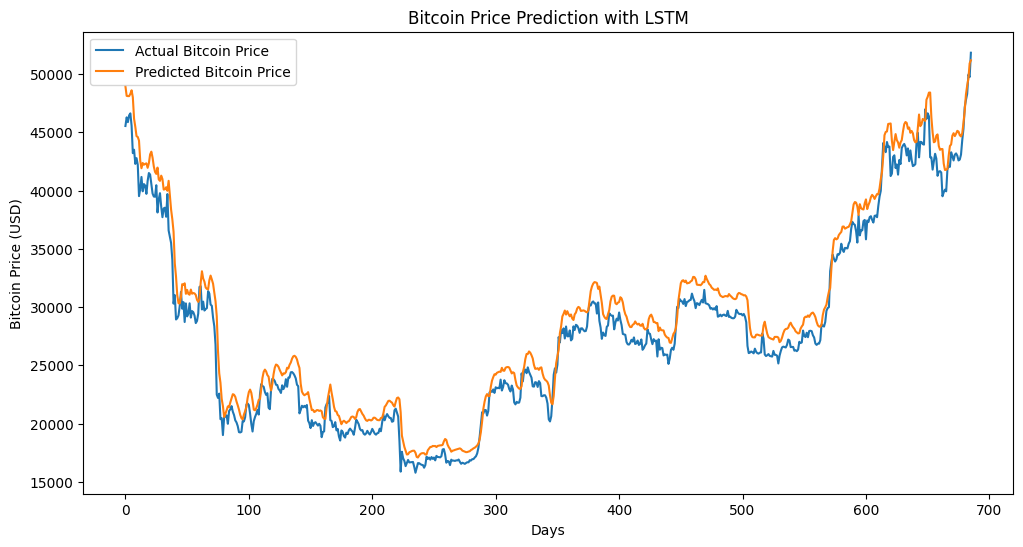

In [9]:
# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(comparison['Actual'], label='Actual Bitcoin Price')
plt.plot(comparison['Predicted'], label='Predicted Bitcoin Price')
plt.title('Bitcoin Price Prediction with LSTM')
plt.xlabel('Days')
plt.ylabel('Bitcoin Price (USD)')
plt.legend()
plt.show()

#**Saving the trained model**

In [10]:
model.save('bitcoin_price_prediction_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [11]:
#import pickle

In [12]:
#filename = 'btcmodel.sav'
#pickle.dump(model, open(filename, 'wb'))

In [13]:
# loading the saved model
#loaded_model = pickle.load(open('btcmodel.sav', 'rb'))

In [14]:
# Keep only the 'Close' prices
btc_data = btc_data[['Close']]
btc_data.head()

,Close
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014


In [15]:
# Normalize the data
scaler = MinMaxScaler()
btc_data_scaled = scaler.fit_transform(btc_data)

In [16]:
# Function to create sequences for training the LSTM model
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        sequence = data[i:i+seq_length]
        target = data[i+seq_length]
        sequences.append(sequence)
        targets.append(target)
    return np.array(sequences), np.array(targets)

In [17]:
# Set sequence length and split data into sequences and targets
sequence_length = 10
X, y = create_sequences(btc_data_scaled, sequence_length)

# Split data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [18]:
# Train the model
#loaded_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=2)
#model.save('bitcoin_price_prediction_model.h5').fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=2)

# Make predictions
#predictions = loaded_model.predict(X_test)
#predictions = model.save('bitcoin_price_prediction_model.h5').predict(X_test)

# Invert the scaling for better visualization
#predictions = scaler.inverse_transform(predictions)
#y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Compare predictions with actual prices
#comparison = pd.DataFrame({'Actual': y_test_inv.flatten(), 'Predicted': predictions.flatten()})
#print(comparison)